# Compare long-term GPP with other versions of AusEFlux

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import contextily as ctx
from odc.geo.xr import assign_crs
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from xarrayMannKendall import Mann_Kendall_test

import sys
sys.path.append('/g/data/xc0/project/AusEFlux/src/')
from _utils import round_coords

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
version='v2.0'

ds_1982 = xr.open_dataset('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/AusEFlux_versions/AusEFlux_GPP_5km_1982_2022_v0.2.nc')['GPP']

if version == 'v2.0':
    ds_2003 = xr.open_dataset('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/AusEFlux_GPP_5km_2003_2023_v2.0.nc')['GPP']
    ds_2003 = ds_2003.sel(time=slice('2003','2022'))
    ds_1982 = ds_1982.sel(time=slice('1982','2022'))

if version == 'v1.1':
    ds_2003 = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_GPP_2003_2022_5km_quantiles_v1.1.nc')['GPP_median']
    ds_2003 = ds_2003.sel(time=slice('2003','2021'))
    ds_2003 = round_coords(ds_2003)
    
    ds_1982 = ds_1982.sel(time=slice('1982','2021'))

In [3]:
mean_1982 = ds_1982.sel(time=slice('2003','2022')).mean('time')
mean_2003 = ds_2003.sel(time=slice('2003','2022')).mean('time')

annual_mean_1982 = ds_1982.resample(time='YS').sum()
annual_mean_2003 = ds_2003.resample(time='YS').sum()

mask = ~np.isnan(mean_2003)
# annual_mean_2003['time'] = annual_mean_2003['time'] + pd.Timedelta(182, 'd')
# annual_mean_1982['time'] = annual_mean_1982['time'] + pd.Timedelta(182, 'd')

## Time-series

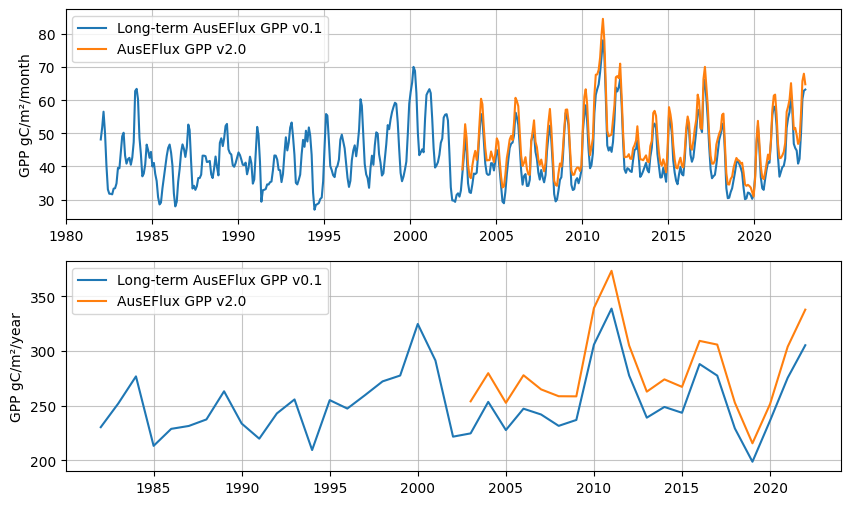

In [4]:
fig,ax=plt.subplots(2,1, figsize=(10,6))
ds_1982.mean(['latitude', 'longitude']).plot(ax=ax[0], label='Long-term AusEFlux GPP v0.1')
ds_2003.mean(['latitude', 'longitude']).plot(ax=ax[0], label=f'AusEFlux GPP {version}')

annual_mean_1982.mean(['latitude', 'longitude']).plot(ax=ax[1], label='Long-term AusEFlux GPP v0.1')
annual_mean_2003.mean(['latitude', 'longitude']).plot(ax=ax[1], label=f'AusEFlux GPP {version}')

ax[0].grid(alpha=0.75)
ax[1].grid(alpha=0.75)
ax[0].set_ylabel('GPP gC/m\N{SUPERSCRIPT TWO}/month')
ax[1].set_ylabel('GPP gC/m\N{SUPERSCRIPT TWO}/year')
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
ax[0].legend()
ax[1].legend();

fig.savefig("/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/AusEFlux_GPP_compare_timeseries.png",
            bbox_inches='tight', dpi=300)

## Long-term mean

In [5]:
corr = xr.corr(ds_2003.sel(time=slice('2003','2022')), ds_1982.sel(time=slice('2003','2022')), dim='time').rename('Pearson Correlation')

corr_data = [annual_mean_2003.mean('time').where(mask),
             annual_mean_1982.mean('time').where(mask),
             ((mean_2003 - mean_1982) / mean_2003 * 100),corr]

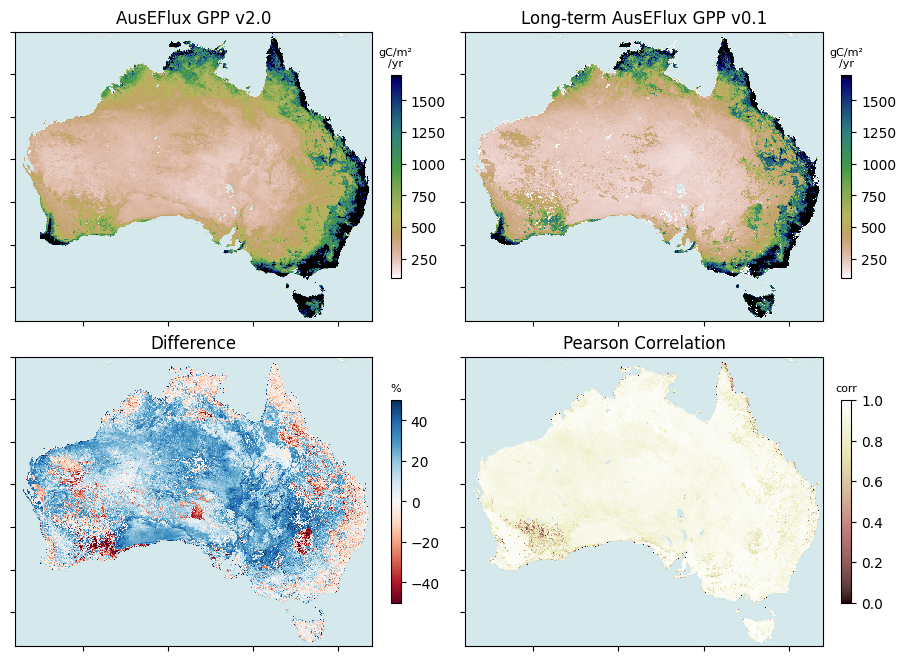

In [6]:
products=[f'AusEFlux GPP {version}', 'Long-term AusEFlux GPP v0.1', 
          'Difference', 'Pearson Correlation']
cmaps = ['gist_earth_r', 'gist_earth_r', 'RdBu', 'pink']

fig,axes = plt.subplots(2,2, figsize=(9,6.5), sharey=True, sharex=True, layout='constrained')

for ax, ds, n, cmap in zip(axes.ravel(), corr_data, products, cmaps):
    if cmap=='pink':
        vmin=0
        vmax=1.0
        im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)
        title='corr'

    if cmap=='RdBu':
        vmin=-50
        vmax=50
        im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)
        title='%'

    if cmap=='gist_earth_r':
        vmin=100
        vmax=1700
        im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)
        title='gC/m\N{SUPERSCRIPT TWO}\n/yr'

    cbar = plt.colorbar(im, ax=ax, shrink=0.7)
    cbar.ax.set_title(title, fontsize=8)
    # cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.set_title(f'{n}')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

fig.savefig("/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/AusEFlux_GPP_compare_perpixel.png",
            bbox_inches='tight', dpi=300)

## Trends

In [7]:
trends_2003 = Mann_Kendall_test(annual_mean_2003,
                               alpha=0.05,
                               method='theilslopes',
                               coords_name={'time':'time','x':'longitude','y':'latitude'}
                            ).compute()

trends_2003 = trends_2003.where(mask.rename({'longitude':'x','latitude':'y'}))            

In [8]:
trends_1982 = Mann_Kendall_test(annual_mean_1982.sel(time=slice('2003', '2022')),
                               alpha=0.05,
                               method='theilslopes',
                               coords_name={'time':'time','x':'longitude','y':'latitude'}
                            ).compute()

trends_1982 = trends_1982.where(mask.rename({'longitude':'x','latitude':'y'}))

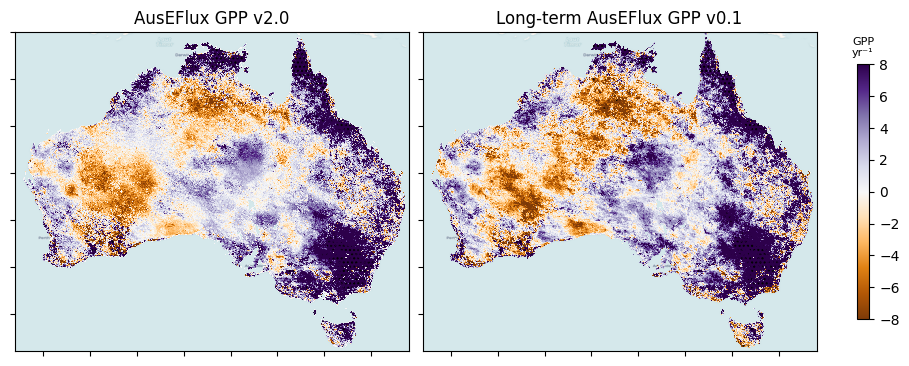

In [11]:
fig,ax = plt.subplots(1,2, figsize=(9,4),sharey=True, layout='constrained')

im = trends_1982.trend.plot(ax=ax[0], cmap='PuOr', vmin=-8, vmax=8, add_colorbar=False, add_labels=False)
im = trends_2003.trend.plot(ax=ax[1], cmap='PuOr', vmin=-8, vmax=8, add_colorbar=False, add_labels=False)

ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)

xr.plot.contourf(trends_1982.trend.where(trends_1982.signif), ax=ax[0], alpha=0, hatches=['....'], add_colorbar=False, add_labels=False)
xr.plot.contourf(trends_2003.trend.where(trends_2003.signif), ax=ax[1], alpha=0, hatches=['....'], add_colorbar=False, add_labels=False)

ax[0].set_title(f'AusEFlux GPP {version}')
ax[1].set_title('Long-term AusEFlux GPP v0.1')

ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])

cb = fig.colorbar(im, ax=ax, shrink=0.65, orientation='vertical')
cb.ax.set_title('GPP\nyr\u207B\u00B9', fontsize=8)
fig.savefig("/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/AusEFlux_GPP_compare_trends.png",
            bbox_inches='tight', dpi=300)